In [1]:
import os
import shutil
import random
import cv2
import albumentations as A
from tqdm import tqdm
import hashlib

# --- HELPER FUNCTION 1 ---
def analyze_nested_image_distribution(base_dir):
    """Analyze image distribution in a potentially nested folder structure."""
    class_counts = {}
    class_images = {}
    
    # List all items in the base directory and filter for directories
    potential_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for class_name in potential_classes:
        class_path = os.path.join(base_dir, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if images:
            if class_name not in class_counts:
                class_counts[class_name] = 0
                class_images[class_name] = []
            
            class_counts[class_name] += len(images)
            # We store the full path directly now for simplicity
            class_images[class_name].extend([os.path.join(class_path, img) for img in images])

    print("\nClass distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")
        
    return class_counts, class_images


# --- HELPER FUNCTION 2 ---
def analyze_flat_distribution(directory):
    """Analyze distribution in the flattened output directory."""
    print("\nFinal balanced distribution:")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"{class_name}: {count} images")


# --- MAIN BALANCING FUNCTION ---
def balance_images_with_guaranteed_uniqueness(base_dir, output_dir):
    """
    Balances an image dataset using powerful augmentations and guarantees 100%
    that no two augmented images are pixel-for-pixel identical by using hashing.
    This version does NOT perform rotation.
    
    Args:
        base_dir (str): Path to the source directory containing class subfolders (e.g., the 'train' split).
        output_dir (str): Path where the balanced dataset will be created.
    """

    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    class_counts, class_images = analyze_nested_image_distribution(base_dir)
    if not class_counts:
        print("No classes found. Exiting.")
        return
        
    max_count = max(class_counts.values())

    # Define the powerful Albumentations pipeline (Corrected and with NO Rotation)
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        
        # Modern Affine transform without 'rotate'
        A.Affine(
            scale=(0.8, 1.2),
            translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
            shear=(-15, 15),
            p=0.9
        ),
        
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),
        
        # Includes the fix for the 'size' parameter
        A.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), p=0.7), 
        
        A.CoarseDropout(max_holes=8, max_height=25, max_width=25, fill_value=0, p=0.5), # This is Cutout
    ])

    print(f"\nBalancing to {max_count} images per class with guaranteed uniqueness...")

    for class_name, image_paths in tqdm(class_images.items(), desc="Processing Classes"):
        class_output_path = os.path.join(output_dir, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        current_count = len(image_paths)
        needed_count = max_count - current_count

        # Step 1: Copy original images
        for src_path in image_paths:
            filename = os.path.basename(src_path)
            dst_path = os.path.join(class_output_path, filename)
            shutil.copy2(src_path, dst_path)

        # Step 2: Generate unique augmented images if needed
        if needed_count > 0 and image_paths:
            generated_hashes = set() # Store fingerprints of generated images
            saved_count = 0

            # Loop until we have saved the exact number of unique images needed
            while saved_count < needed_count:
                img_path_to_augment = random.choice(image_paths)
                
                try:
                    image = cv2.imread(img_path_to_augment)
                    if image is None: 
                        continue
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    augmented = transform(image=image)
                    aug_image = augmented['image']

                    # Compute the hash (fingerprint) of the new image's pixel data
                    image_hash = hashlib.sha256(aug_image.tobytes()).hexdigest()

                    # If the fingerprint is NEW, save the image
                    if image_hash not in generated_hashes:
                        generated_hashes.add(image_hash)
                        
                        aug_name = f"aug_{class_name}_{saved_count:04d}.jpg"
                        aug_path = os.path.join(class_output_path, aug_name)
                        
                        aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
                        cv2.imwrite(aug_path, aug_image_bgr)
                        
                        saved_count += 1
                    # If duplicate, do nothing and let the loop try again

                except Exception as e:
                    print(f"\nCould not augment image {img_path_to_augment}: {e}")

    print("\nBalancing complete!")
    analyze_flat_distribution(output_dir)

In [2]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def split_original_data_stratified(base_dir, output_dir, train_size=0.8, val_size=0.1, test_size=0.1):
    """
    Splits the original, un-augmented dataset into train, validation, and test sets
    using stratification to handle class imbalance.
    
    Args:
        base_dir (str): Path to the directory with the original class folders.
        output_dir (str): Path where the 'train', 'val', and 'test' folders will be created.
        train_size (float): Percentage of data for training.
        val_size (float): Percentage of data for validation.
        test_size (float): Percentage of data for testing.
    """
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    print(f"Creating stratified split dataset at: {output_dir}")

    # 1. Collect all file paths and their corresponding labels
    print("Collecting file paths and labels...")
    filepaths = []
    labels = []
    class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        filepaths.extend(image_files)
        labels.extend([class_name] * len(image_files))

    # 2. Perform the first split (train vs. temp)
    # This separates the training set from the validation and testing sets.
    X_train, X_temp, y_train, y_temp = train_test_split(
        filepaths, labels, 
        train_size=train_size, 
        stratify=labels,
        random_state=42 # for reproducibility
    )

    # 3. Perform the second split (validation vs. test) on the temporary set
    # We need to calculate the correct proportion for the test set from the temporary set
    relative_test_size = test_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, 
        test_size=relative_test_size, 
        stratify=y_temp,
        random_state=42 # for reproducibility
    )

    print("\nSplit successful:")
    print(f"Training set size: {len(X_train)} images")
    print(f"Validation set size: {len(X_val)} images")
    print(f"Test set size: {len(X_test)} images")

    # 4. Create directories and copy files
    print("\nCopying files to their new directories...")
    split_dirs = {'train': X_train, 'val': X_val, 'test': X_test}
    for split_name, file_list in split_dirs.items():
        split_path = os.path.join(output_dir, split_name)
        os.makedirs(split_path, exist_ok=True)
        # Create class subdirectories
        for class_name in class_names:
            os.makedirs(os.path.join(split_path, class_name), exist_ok=True)
        
        # Copy files
        for src_path in tqdm(file_list, desc=f"Copying {split_name} files"):
            filename = os.path.basename(src_path)
            class_name = os.path.basename(os.path.dirname(src_path))
            dst_path = os.path.join(split_path, class_name, filename)
            shutil.copy2(src_path, dst_path)
            
    print("\nStratified splitting complete!")


# --- How to use the new function ---
# The end-to-end workflow remains the same, just call the new function.

# 1. DEFINE YOUR PATHS
original_data_dir = '/kaggle/input/mendeley-old-dataset-final/alzheimer mendeley/OriginalDataset' 
split_data_dir = '/kaggle/working/dataset_split'
balanced_train_dir = '/kaggle/working/balanced_train_data'

# 2. SPLIT FIRST (using the new stratified function)!
split_original_data_stratified(original_data_dir, split_data_dir, train_size=0.8, val_size=0.1, test_size=0.1)

# 3. AUGMENT THE TRAINING SET ONLY!
original_train_set_path = os.path.join(split_data_dir, 'train')
balance_images_with_guaranteed_uniqueness(original_train_set_path, balanced_train_dir)

# 4. PREPARE FOR MODEL TRAINING
print("\nWorkflow Complete!")
print(f"Train your model on data from: {balanced_train_dir}")
print(f"Validate your model on data from: {os.path.join(split_data_dir, 'val')}")
print(f"Test your model on data from: {os.path.join(split_data_dir, 'test')}")

Creating stratified split dataset at: /kaggle/working/dataset_split

Split successful:
Training set size: 5120 images
Validation set size: 640 images
Test set size: 640 images

Copying files to their new directories...


Copying test files: 100%|██████████| 640/640 [00:03<00:00, 185.74it/s]
/tmp/ipykernel_19/2153406660.py:89: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=25, max_width=25, fill_value=0, p=0.5), # This is Cutout



Stratified splitting complete!

Class distribution:
Mild Dementia: 717 images
Moderate Dementia: 51 images
Non Demented: 2560 images
Very mild Dementia: 1792 images

Balancing to 2560 images per class with guaranteed uniqueness...


Processing Classes: 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


Balancing complete!

Final balanced distribution:
Mild Dementia: 2560 images
Moderate Dementia: 2560 images
Non Demented: 2560 images
Very mild Dementia: 2560 images

Workflow Complete!
Train your model on data from: /kaggle/working/balanced_train_data
Validate your model on data from: /kaggle/working/dataset_split/val
Test your model on data from: /kaggle/working/dataset_split/test


2025-09-17 16:18:10.142251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758125890.377057      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758125890.445020      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758125903.901193      19 gpu_device.cc:2022] Created device /job:localhost/repl

Model created successfully. Here is the summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 87, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 41, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,301,988 (12.60 MB)

 Trainable params: 3,301,508 (12.59 MB)

 Non-trainable params: 480 (1.88 KB)


Preparing data generators with validation checks...
Checking for training directory: /kaggle/working/balanced_train_data
Checking for validation directory: /kaggle/working/dataset_split/val
Checking for testing directory: /kaggle/working/dataset_split/test
Found 10240 images belonging to 4 classes.
Train generator found 10240 images in 4 classes.
Found 640 images belonging to 4 classes.
Validation generator found 640 images in 4 classes.
Found 640 images belonging to 4 classes.
Test generator found 640 images in 4 classes.

Setting up callbacks...

ALL CHECKS PASSED. Starting training for 50 epochs...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1758125909.749036      64 service.cc:148] XLA service 0x7a8110014bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758125909.750131      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758125909.750152      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758125910.220382      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/160 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.3099 - loss: 2.3907

I0000 00:00:1758125915.369215      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4901 - loss: 1.3444
Epoch 1: val_accuracy improved from -inf to 0.34062, saving model to /kaggle/working/best_oasis_model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - accuracy: 0.4903 - loss: 1.3432 - val_accuracy: 0.3406 - val_loss: 1.6209
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6024 - loss: 0.9520
Epoch 2: val_accuracy improved from 0.34062 to 0.36250, saving model to /kaggle/working/best_oasis_model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6023 - loss: 0.9521 - val_accuracy: 0.3625 - val_loss: 1.8655
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7203 - loss: 0.6776
Epoch 3: val_accuracy improved from 0.36250 to 0.44375, saving model to /kaggle/working/best_oasis_model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7203 - loss: 0.6774 - val_accuracy: 0.4437 - val_loss: 1.5151
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy

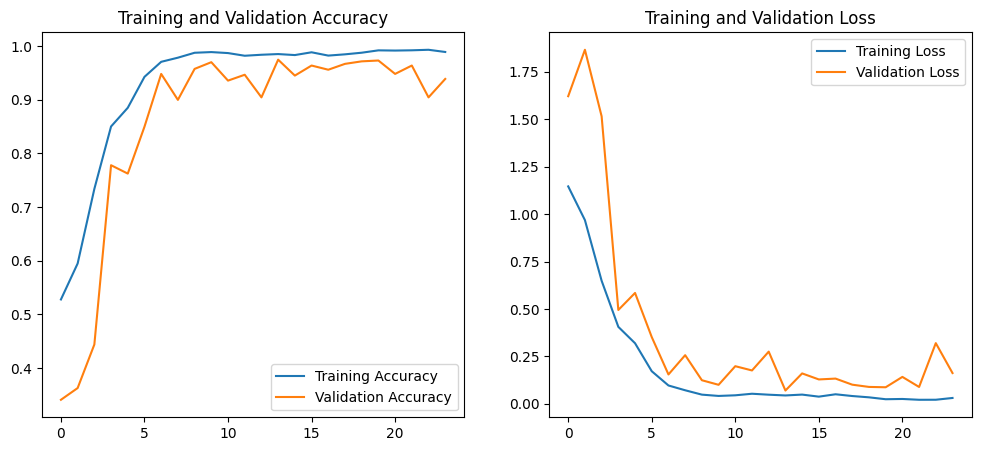

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       0.94      0.97      0.95        90
 Moderate Dementia       1.00      1.00      1.00         6
      Non Demented       0.97      0.98      0.98       320
Very mild Dementia       0.98      0.96      0.97       224

          accuracy                           0.97       640
         macro avg       0.97      0.98      0.97       640
      weighted avg       0.97      0.97      0.97       640



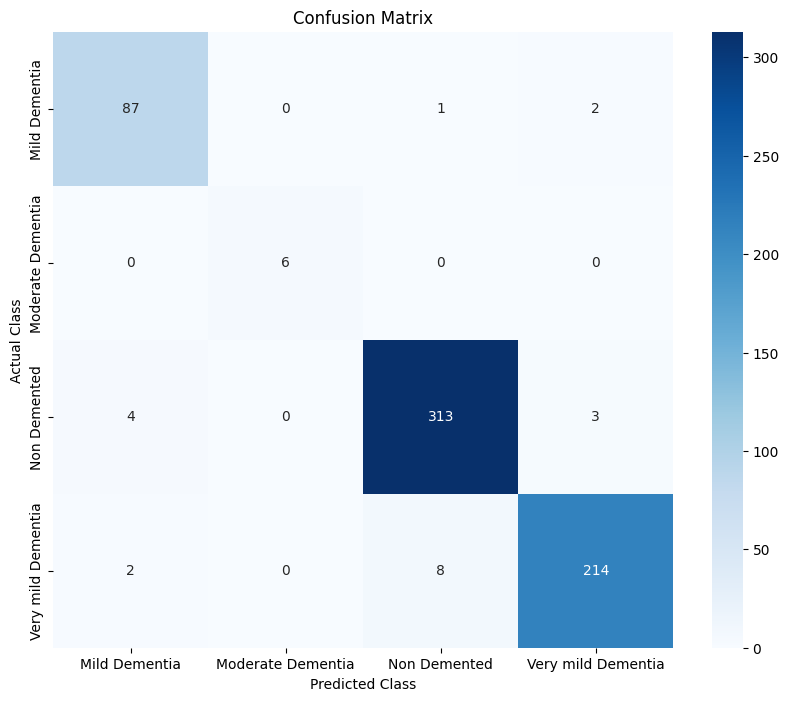

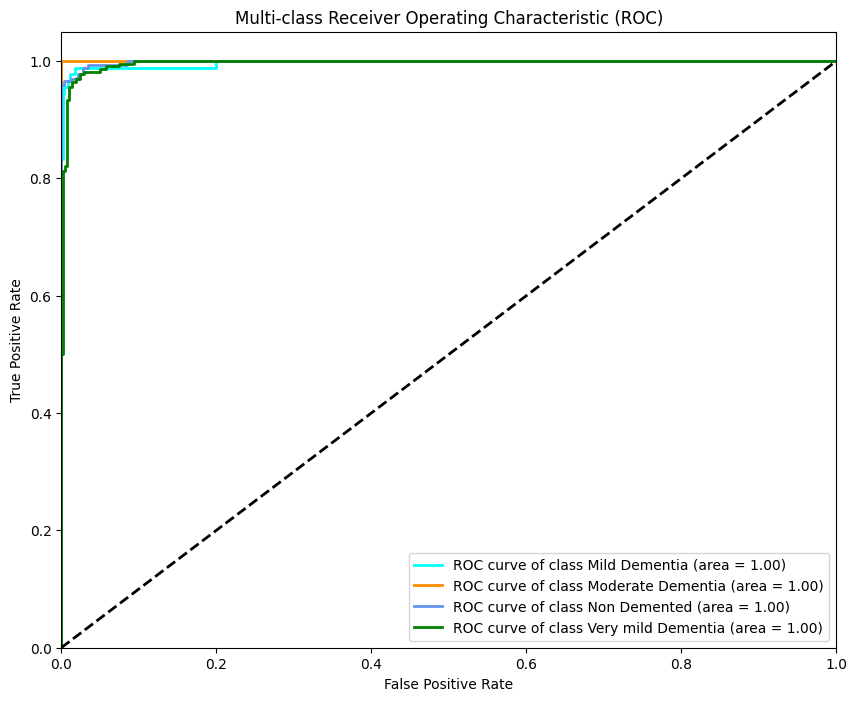

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


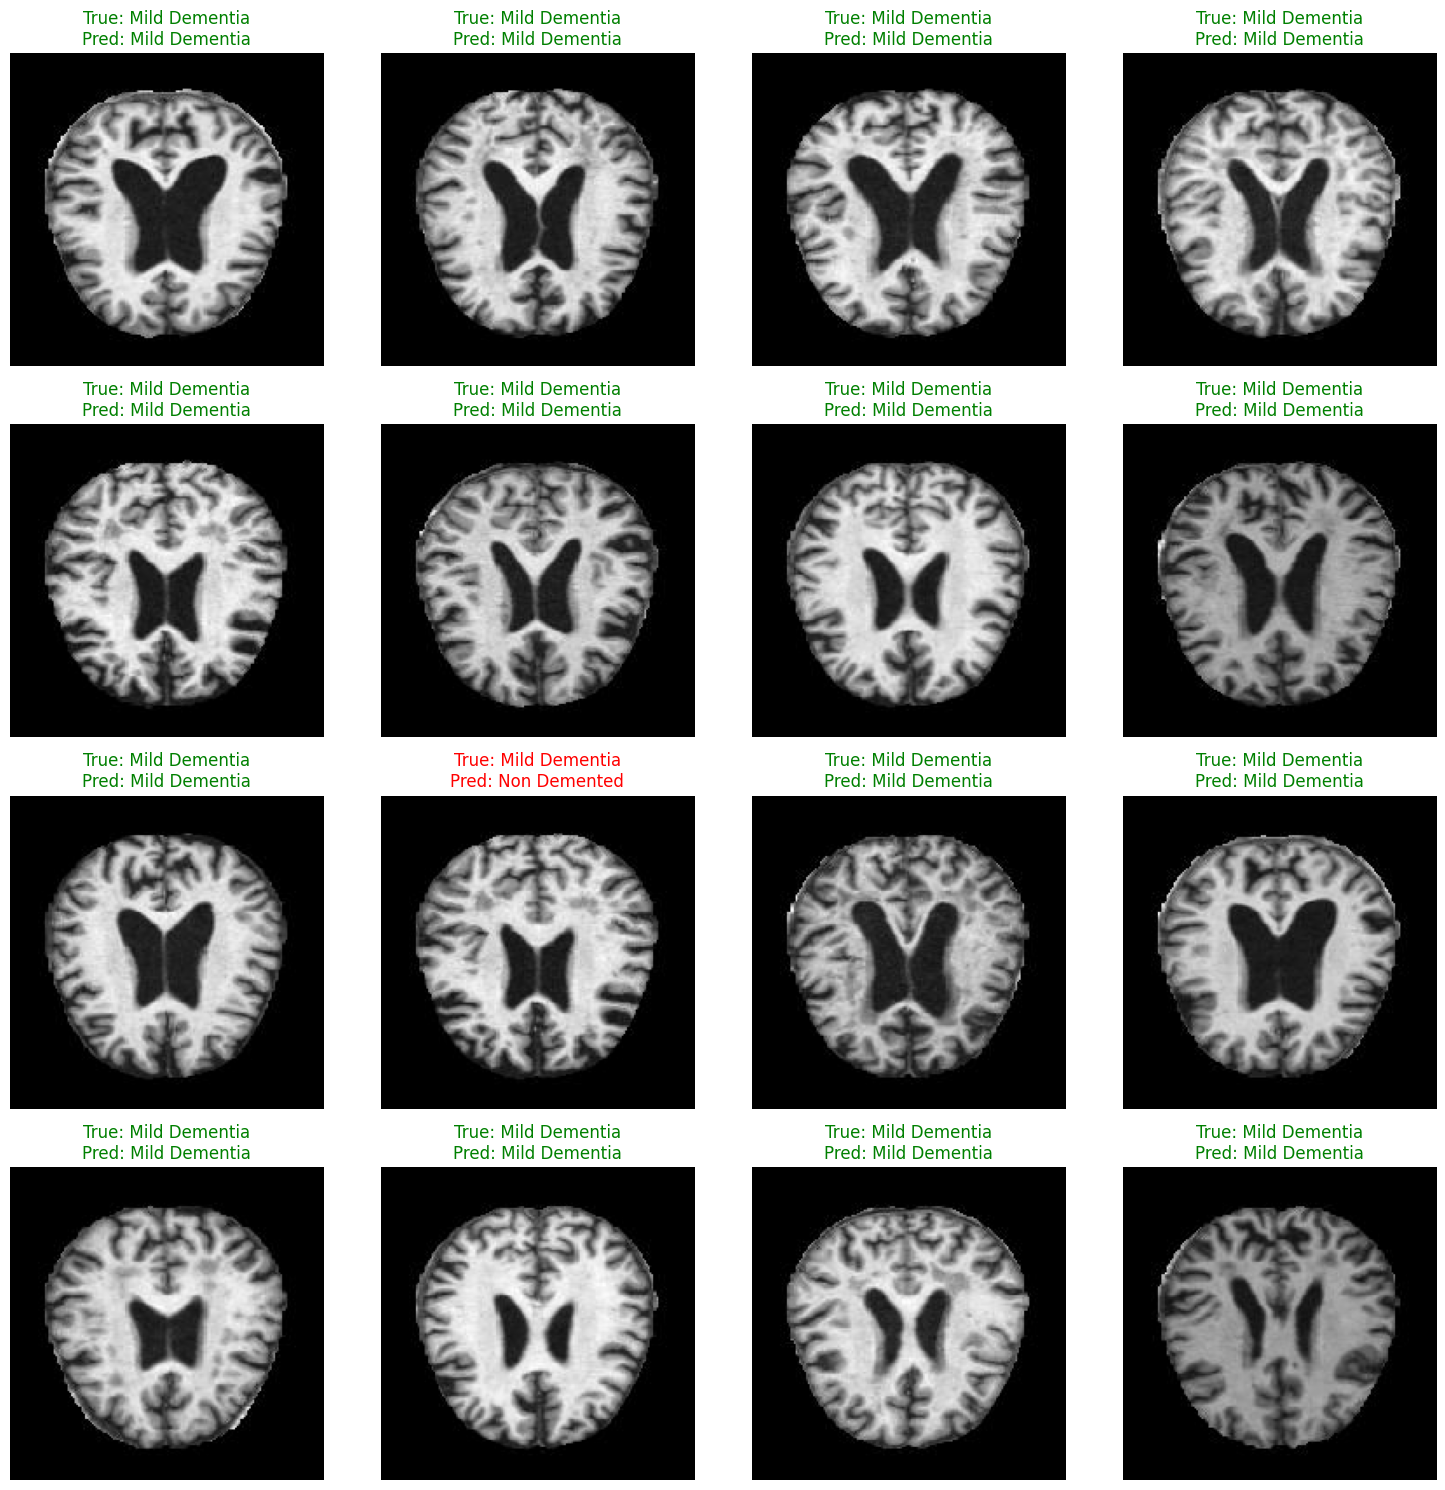

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from itertools import cycle

def create_cnn_model(input_shape, num_classes):
    """
    Creates a 3-layer CNN model with Batch Normalization and a Dense classification head.
    """
    model = Sequential()

    # --- Convolutional Blocks (unchanged) ---
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # --- Flattening and Classification Head ---
    model.add(Flatten())
    
    # --- FIX: Add Dense layers for classification ---
    model.add(Dense(128, activation='relu')) # Learn combinations of features
    model.add(BatchNormalization())          # Stabilize the dense layer
    model.add(Dropout(0.5))                  # Regularization to prevent overfitting

    # --- Output Layer (unchanged) ---
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 1. Define Constants and Paths ---
IMG_HEIGHT = 180
IMG_WIDTH = 180
NUM_CLASSES = 4
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
BATCH_SIZE = 64
EPOCHS = 50

BALANCED_TRAIN_DIR = '/kaggle/working/balanced_train_data'
SPLIT_DATA_DIR = '/kaggle/working/dataset_split'
VALIDATION_DIR = os.path.join(SPLIT_DATA_DIR, 'val')
TEST_DIR = os.path.join(SPLIT_DATA_DIR, 'test')
BEST_MODEL_PATH = '/kaggle/working/best_oasis_model.keras'

# --- 2. Create the Model ---
model = create_cnn_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
print("Model created successfully. Here is the summary:")
model.summary()


# --- 3. Prepare Data Generators (with Diagnostic Checks) ---
print("\nPreparing data generators with validation checks...")

# --- Check if directories exist before creating generators ---
print(f"Checking for training directory: {BALANCED_TRAIN_DIR}")
assert os.path.exists(BALANCED_TRAIN_DIR), f"ERROR: Training directory not found at {BALANCED_TRAIN_DIR}"

print(f"Checking for validation directory: {VALIDATION_DIR}")
assert os.path.exists(VALIDATION_DIR), f"ERROR: Validation directory not found at {VALIDATION_DIR}"

print(f"Checking for testing directory: {TEST_DIR}")
assert os.path.exists(TEST_DIR), f"ERROR: Testing directory not found at {TEST_DIR}"


train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    BALANCED_TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

# --- Check if generators found any images ---
print(f"Train generator found {train_generator.samples} images in {train_generator.num_classes} classes.")
assert train_generator.samples > 0, "ERROR: No images found in the training directory. Training cannot start."

validation_generator = val_test_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)
print(f"Validation generator found {validation_generator.samples} images in {validation_generator.num_classes} classes.")
assert validation_generator.samples > 0, "ERROR: No images found in the validation directory."

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)
print(f"Test generator found {test_generator.samples} images in {test_generator.num_classes} classes.")
assert test_generator.samples > 0, "ERROR: No images found in the testing directory."


# --- 4. Set Up Callbacks to Save the Best Model ---
print("\nSetting up callbacks...")
checkpoint = ModelCheckpoint(
    filepath=BEST_MODEL_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)


# --- 5. Train the Model ---
print(f"\nALL CHECKS PASSED. Starting training for {EPOCHS} epochs...")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)


# --- 6. Load the Best Saved Model and Evaluate on Test Data ---
print("\nTraining finished. Loading the best model for final evaluation...")

if os.path.exists(BEST_MODEL_PATH):
    best_model = load_model(BEST_MODEL_PATH)
else:
    print("Best model was not saved. Using the model from the last epoch of training.")
    best_model = model

print("\nEvaluating the best model on the test dataset...")
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


# --- 7. Visualize Model Performance ---
print("\nGenerating performance visualizations...")

# --- Plot Training & Validation Accuracy and Loss ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Get predictions for the entire test set
# The steps parameter ensures we go through the entire test set once
# FIX: Cast the result of np.ceil to an integer
predictions = best_model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size)))
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# --- Confusion Matrix and Classification Report ---
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# --- ROC-AUC Curve (One-vs-Rest Strategy for Multi-class) ---
true_classes_binarized = tf.keras.utils.to_categorical(true_classes, num_classes=NUM_CLASSES)
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# --- Show Some Predictions on Test Images ---
x_test, y_test = next(test_generator)
y_test = y_test.astype(int)
predictions_batch = best_model.predict(x_test)
predicted_classes_batch = np.argmax(predictions_batch, axis=1)
plt.figure(figsize=(15, 15))
for i in range(min(16, len(x_test))):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_test[i])
    true_label_name = class_labels[y_test[i]]
    predicted_label_name = class_labels[predicted_classes_batch[i]]
    title_color = 'green' if true_label_name == predicted_label_name else 'red'
    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}", color=title_color)
    plt.axis('off')
plt.tight_layout()
plt.show()

